# Human-intepretable Machine Learning - The road to Explainable AI

Interpreting Machine Learning models is no longer a luxury but a necessity. To understand and need and importance of human-interpretable machine learning, feel free to check out the article, [_Explainable Artificial Intelligence (Part 1) — The Importance of Human Interpretable Machine Learning_](https://towardsdatascience.com/human-interpretable-machine-learning-part-1-the-need-and-importance-of-model-interpretation-2ed758f5f476).

In this tutorial we will take a look at various ways to explain potential black-box machine learning models in a model-agnostic way. We will be working on a real-world dataset on Census income, also known as the Adult dataset available in the UCI ML Repository where we will be predicting if the potential income of people is more than $50K/yr or not.

The purpose of this tutorial is manifold. The first main objective is to familiarize ourselves with the major state-of-the-art model interpretation frameworks out there (a lot of them being extensions of LIME - the original framework and approach proposed for model interpretation).

[__LIME__](https://github.com/marcotcr/lime) (short for local interpretable model-agnostic explanations) is based on the work presented in the paper, ["Why Should I Trust You?": Explaining the Predictions of Any Classifier"](https://arxiv.org/pdf/1602.04938.pdf) which talks about a novel explanation technique that explains the predictions of any classifier in an interpretable and faithful manner, by learning an interpretable model locally around the prediction. It also covers a method to explain models by presenting representative individual predictions and their explanations in a non-redundant way.

We cover usage of the following model interpretation frameworks in our tutorial.
- [__ELI5__](https://github.com/TeamHG-Memex/eli5)
- [__Skater__](https://github.com/datascienceinc/Skater)
- [__SHAP__](https://github.com/slundberg/shap)

The major model interpretation techniques we will be covering in this tutorial include the following.
- Feature Importances
- Partial Dependence Plots
- Model Prediction Explanations with Local Interpretation
- Building Interpretable Models with Surrogate Tree-based Models
- Model Prediction Explanation with SHAP values
- Dependence & Interaction Plots with SHAP

_Tutorial by [Dipanjan (DJ) Sarkar](https://www.linkedin.com/in/dipanzan/)_

# Load necessary dependencies

In [1]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

# Load the Census Income Dataset

In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])
data.shape, labels.shape

((32561, 12), (32561,))

# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


| Attribute Name | Type | Description |
|-----------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age | Continuous | Represents age of the person |
| Workclass | Categorical | Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) |
| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
| Occupation | Categorical | Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
| Capital Gain | Continuous | The total capital gain for the person |
| Capital Loss | Continuous | The total capital loss for the person |
| Hours per week | Continuous | Total hours spent working per week |
| Country | Categorical | The country where the person is residing |
| Income Label (labels) | Categorical  (class label) | The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) |                                                                                                                                                                |

We have a total of 12 features and our objective is to predict if the income of a person will be more than \$50K (True) or less than \$50K (False). Hence we will be building and interpreting a classification model

In [3]:
data.head()

Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
4  28.0            Private           13.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   Capital Loss  Hours per week         Country  
0           0.0            40.0   United-States  
1           0.0            13.0   United-States  
2           0.0            40.0   United-States  
3           0.0            40.0   United-States  
4           0.0            40.0            Cuba

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


# Basic Feature Engineering
Here we convert the categorical columns with string values to numeric representations. 
Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [5]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             1   
1  50.0          6           13.0               2           4             0   
2  38.0          4            9.0               0           6             1   
3  53.0          4            7.0               2           6             0   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

## Viewing distribution of people with <=  \$50K (False) and > \$50K (True) income

In [6]:
Counter(labels)

Counter({0: 24720, 1: 7841})

# Building Train and Test Datasets

For any machine learning model, we always need train and test datasets. We will be building the model on the train dataset and test the performance on the test dataset. We maintain two datasets (one with the encoded categorical values and one with the original values) so we can train with the encoded dataset but use the original dataset as needed later on for model interpretation. 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((22792, 12), (9769, 12))

In [8]:
X_train.head(3)

Age  Workclass  Education-Num  Marital Status  Occupation  \
19749  34.0          6            9.0               2           5   
1216   48.0          6           10.0               2           3   
27962  23.0          7           10.0               2          10   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
19749             5     4    0           0.0        2179.0            12.0   
1216              0     0    1        7688.0           0.0            40.0   
27962             0     4    1           0.0           0.0            30.0   

       Country  
19749       39  
1216        39  
27962       39

In [9]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
X_train_disp.shape, X_test_disp.shape

((22792, 12), (9769, 12))

In [10]:
X_train_disp.head(3)

Age          Workclass  Education-Num       Marital Status  \
19749  34.0   Self-emp-not-inc            9.0   Married-civ-spouse   
1216   48.0   Self-emp-not-inc           10.0   Married-civ-spouse   
27962  23.0          State-gov           10.0   Married-civ-spouse   

             Occupation Relationship                 Race      Sex  \
19749   Farming-fishing         Wife                White   Female   
1216       Craft-repair      Husband   Amer-Indian-Eskimo     Male   
27962    Prof-specialty      Husband                White     Male   

       Capital Gain  Capital Loss  Hours per week         Country  
19749           0.0        2179.0            12.0   United-States  
1216         7688.0           0.0            40.0   United-States  
27962           0.0           0.0            30.0   United-States

# Training the classification model

We will now train and build a basic boosting classification model on our training data using the popular [XGBoost](https://xgboost.readthedocs.io/en/latest/) 
framework, an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable 

In [11]:
%%time

import xgboost as xgb

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

Wall time: 8.16 s


# Making predictions on the test data

Here we do the usual, use the trained model to make predictions on the test dataset

In [12]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

# Model Performance Evaluation

Time to put the model to the test! Let's evaluate how our model has performed with its predictions on the test data. 
We use my nifty `model_evaluation_utils` module for this which leverages `scikit-learn` internally to give us 
standard classification model evaluation metrics

In [13]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.76      0.67      0.71      2314

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6972   483
        1        775  1539


# Default Model Interpretation Methods

By default it is difficult to gauge on specific model interpretation methods for machine learning models out of the box. 
Parametric models like logistic regression are easier to interpret given that the total number of parameters of the model
are fixed regardless of the volume of data and one can make some interpretation of the model's prediction decisions leveraging
the parameter coefficients.

Non-parametric models are harder to interpret given that the total number of parameters remain unbounded and increase
with the increase in the data volume. Some non-parametric models like tree-based models do have some out of the box model 
interpretation methods like feature importance which helps us in understanding which features might be influential in
the model making its prediction decisions

## Classic feature importances from XGBoost

Here we try out the global feature importance calcuations that come with XGBoost. The model enables us to view feature importances based on the following.

- __Feature Weights:__ This is based on the number of times a feature appears in a tree across the ensemble of trees
- __Gain:__ This is based on the average gain of splits which use the feature
- __Coverage:__ This is based on the average coverage (number of samples affected) of splits which use the feature

Note that they all contradict each other, which motivates the use of model interpretation frameworks like SHAP which uses something known as SHAP values, which claim to come with consistency guarantees (meaning they will typically order the features correctly).

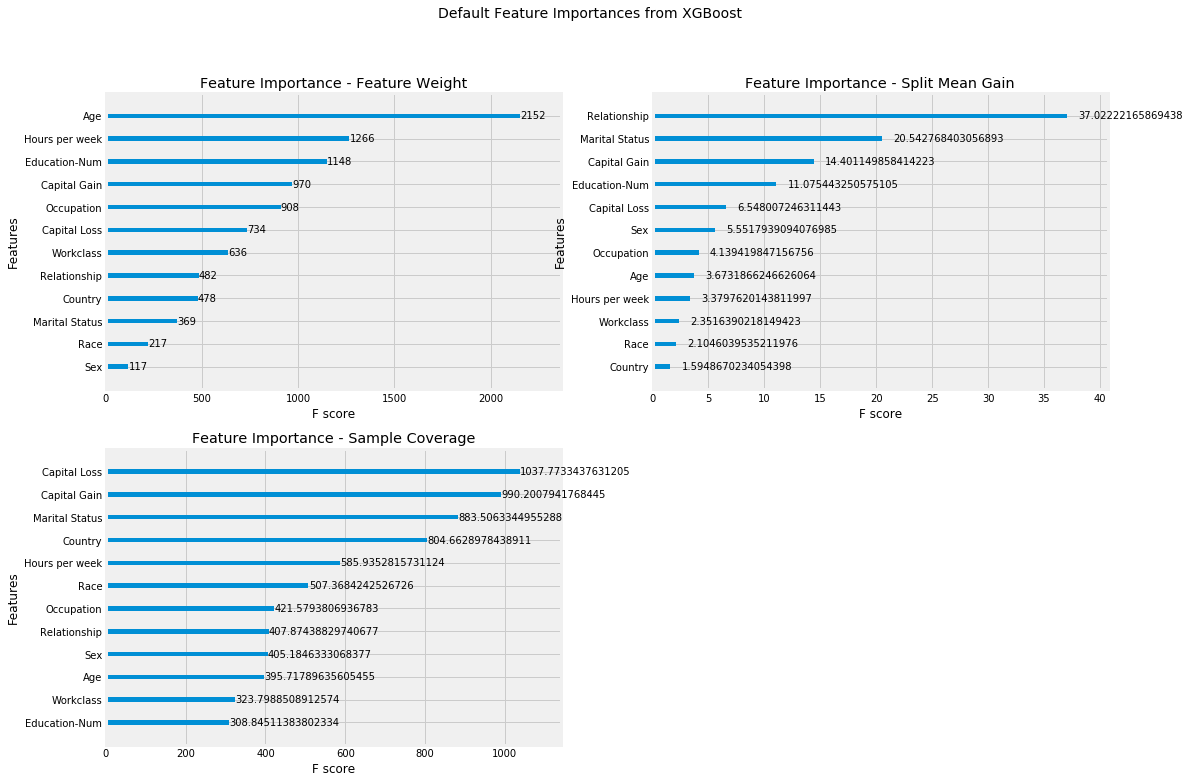

In [14]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

# Model Interpretation with ELI5

[__ELI5__](https://github.com/TeamHG-Memex/eli5) is a Python package which helps to debug machine learning classifiers and explain their predictions in an easy to understand an intuitive way. It is perhaps the easiest of the three machine learning frameworks to get started with since it involves minimal reading of documentation! However it doesn't support true model-agnostic interpretations and support for models are mostly limited to tree-based and other parametric\linear models. Let's look at some intuitive ways of model interpretation with ELI5 on our classification model. 

### Installation Instructions

We recommend installing this framework using __`pip install eli5`__ since the `conda` version appears to be a bit out-dated. Also feel free to check out [__the documentation__](https://eli5.readthedocs.io/en/latest/overview.html) as needed.

## Feature Importances with ELI5

Typically for tree-based models ELI5 does nothing special but uses the out-of-the-box feature importance computation methods which we discussed in the previous section. By default, __'gain'__ is used, that is the average gain of the feature when it is used in trees.

In [15]:
eli5.show_weights(xgc.get_booster())

## Explaining Model Prediction Decisions with ELI5

One of the best way to explain model prediction decisions to either a technical or a more business-oriented individual, is to  examine individual data-point predictions. Typically, ELI5 does this by showing weights for each feature depicting how influential it might have been in contributing to the final prediction decision across all trees. The idea for weight calculation is described in http://blog.datadive.net/interpreting-random-forests/; ELI5 provides an independent implementation of this algorithm for XGBoost and most scikit-learn tree ensembles which is definitely on the path towards model-agnostic interpretation but not purely model-agnostic like LIME.

Typically, the prediction can be defined as the sum of the feature contributions + the “bias” (i.e. the mean given by the topmost region that covers the entire training set)

### Predicting when a person's income <= \$50K 

Here we can see the most influential features being the __`Age`, `Hours per week`, `Marital Status`, `Occupation` & `Relationship`__

In [16]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns) ,show_feature_values=True)

Actual Label: 0
Predicted Label: 0


### Predicting when a person's income > \$50K 

Here we can see the most influential features being the __`Education`, `Relationship`, `Occupation`, `Hours per week` & `Marital Status`__

In [17]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], feature_names=list(data.columns) ,show_feature_values=True)

Actual Label: 1
Predicted Label: 1


It is definitely interesting to see how similar features play an influential role in explaining model prediction decisions for both classes!

# Model Interpretation with Skater

Skater is a unified framework to enable Model Interpretation for all forms of models to help one build an Interpretable machine learning system often needed for real world use-cases using a model-agnostic approach. It is an open source python library designed to demystify the learned structures of a black box model both globally(inference on the basis of a complete data set) and locally(inference about an individual prediction).

![](https://d3ansictanv2wj.cloudfront.net/Figure5-452aaf48771d7e201175954c1de6eed1.png)

Skater originally started off as a fork of LIME but then broke out as an independent framework of it's own with a wide variety of feature and capabilities for model-agnostic interpretation for any black-box models. The project was started as a research idea to find ways to enable better interpretability(preferably human interpretability) to predictive "black boxes" both for researchers and practioners. 

### Install Skater

You can typically install Skater using a simple __`pip install skater`__. For detailed information on the dependencies and intallation instruction check out [installing skater](https://datascienceinc.github.io/Skater/install.html).

### 📖 Documentation

We recommend you to check out the detailed documentation of Skater

|  |  |
|---------------------------------------------------------------------------------------|----------------------------------------------|
| [Overview](https://datascienceinc.github.io/Skater/overview.html) | Introduction to the Skater library |
| [Installing](https://datascienceinc.github.io/Skater/install.html) | How to install the Skater library |
| [Tutorial](https://datascienceinc.github.io/Skater/tutorial.html) | Steps to use Skater effectively. |
| [API Reference](https://datascienceinc.github.io/Skater/api.html) | The detailed reference for Skater's API. |
| [Contributing](https://github.com/datascienceinc/Skater/blob/master/CONTRIBUTING.rst) | Guide to contributing to the Skater project. |
| [Examples](https://datascienceinc.github.io/Skater/gallery.html) | Interactive notebook examples |


### Algorithms

```
+---------+---------+-----+-----------+-----------+--------------+--------------+--------------------+------------------+
| Scope of Interpretation |            Algorithms                                                                       |
+=========+=========+=====+===========+===========+==============+==============+=======================================+
| Global Interpretation   | `Model agnostic Feature Importance <https://tinyurl.com/feature-importance>`_               |
+---------+---------+-----+-----------+-----------+--------------+--------------+--------------------+------------------+
| Global Interpretation   | `Model agnostic Partial Dependence Plots <https://tinyurl.com/partial-dependence>`_         | 
+---------+---------+-----+-----------+-----------+--------------+--------------+--------------------+------------------+
| Local Interpretation    | `Local Interpretable Model Explanation(LIME) <https://tinyurl.com/lime-explanation>`_       |
+---------+---------+-----+-----------+-----------------------------------------+--------------------+------------------+
| Local Interpretation    | DNNs      | - `Layer-wise Relevance Propagation <https://tinyurl.com/e-layerwise>`_         |
|                         |           |   (e-LRP): image                                                                |
|                         |           |                                                                                 |
|                         |           | - `Occlusion  <https://tinyurl.com/dnn-occlusion>`_ : image                     |
|                         |           |                                                                                 |
|                         |           | - `Integrated Gradient <https://tinyurl.com/integrated-gradient>`_              |
|                         |           |   image and text                                                                |
+---------+---------+-----+-----------+-----------------------------------------+--------------------+------------------+
| Global and Local        | `Scalable Bayesian Rule Lists <https://tinyurl.com/rule-list-sbr>`_                         |
| Interpretation          |                                                                                             |
|                         | `Tree Surrogates <https://tinyurl.com/treesurrogates>`_                                     |
+---------+---------+-----+-----------+-----------+--------------+--------------+--------------------+------------------+
``` 
 

### Usage and Examples
Since the project is under active development, the best way to understand usage would be to follow the examples mentioned in the [Gallery of Interactive Notebook](https://datascienceinc.github.io/Skater/gallery.html)

# Global Interpretations with Skater

A predictive model is a mapping from an input space to an output space. Interpretation algorithms are divided into those that offer statistics and metrics on regions of the domain, such as the marginal distribution of a feature, or the joint distribution of the entire training set. In an ideal world there would exist some representation that would allow a human to interpret a decision function in any number of dimensions. Given that we generally can only intuit visualizations of a few dimensions at time, global interpretation algorithms either aggregate or subset the feature space.

Currently, model-agnostic global interpretation algorithms supported by skater include partial dependence and feature importance with a very new release of tree-surrogates also. We will be covering feature importance and partial dependence plots here

## Creating an interpretation object
The general workflow within the skater package is to create an interpretation, create a model, and run interpretation algorithms. Typically, an `Interpretation` consumes a dataset, and optionally some metadata like feature names and row ids. Internally, the `Interpretation` will generate a `DataManager` to handle data requests and sampling.

- __Local Models(`InMemoryModel`):__ To create a skater model based on a local function or method, pass in the predict function to an `InMemoryModel`. A user can optionally pass data samples to the examples keyword argument. This is only used to infer output types and formats. Out of the box, skater allows models return `numpy` arrays and `pandas` dataframes.

- __Operationalized Model(`DeployedModel`):__ If your model is accessible through an API, use a `DeployedModel`, which wraps the requests library. `DeployedModels` require two functions, an input formatter and an output formatter, which speak to the requests library for posting and parsing. The input formatter takes a `pandas` DataFrame or a `numpy` ndarray, and returns an object (such as a dict) that can be converted to JSON to be posted. The output formatter takes a requests.response as an input and returns a `numpy` ndarray or `pandas` DataFrame.

We will use the following workflow:

- Build an interpretation object
- Build an in-memory model
- Perform interpretations

In [18]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [19]:
interpreter = Interpretation(training_data=X_test, training_labels=y_test, feature_names=list(data.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, target_names=['$50K or less', 'More than $50K'])

## Feature Importances with Skater

Feature importance is generic term for the degree to which a predictive model relies on a particular feature. The skater feature importance implementation is based on an information theoretic criteria, measuring the entropy in the change of predictions, given a perturbation of a given feature. The intuition is that the more a model's decision criteria depend on a feature, the more we'll see predictions change as a function of perturbing a feature. The default method used is `prediction-variance` which is the mean absolute value of changes in predictions, given perturbations in the data.

2018-10-30 21:20:05,700 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 12 seconds

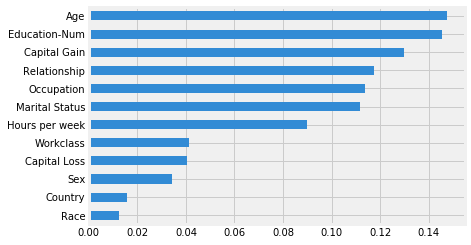

In [23]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, n_samples=23000)

## Partial Dependence

Partial Dependence describes the marginal impact of a feature on model prediction, holding other features in the model constant. The derivative of partial dependence describes the impact of a feature (analogous to a feature coefficient in a regression model). This has been adapted from _T. Hastie, R. Tibshirani and J. Friedman, Elements of Statistical Learning Ed. 2, Springer_.  2009. 

The partial dependence plot (PDP or PD plot) shows the marginal effect of a feature on the predicted outcome of a previously fit model. PDPs can show if the relationship between the target and a feature is linear, monotonic or more complex. Skater can show 1-D as well as 2-D PDPs

### PDP of 'Age' affecting model prediction

Looks like the middle-aged people have a slightly higher chance of making more money as compared to younger or older people

2018-10-30 21:49:42,333 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[44/44] grid cells ████████████████████ Time elapsed: 20 seconds

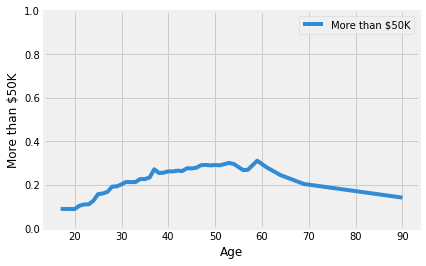

In [42]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

### PDP of 'Education Num' affecting model prediction

Looks like higher the education level, the better the chance of making more money. Not surprising!

2018-10-30 21:49:14,095 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[16/16] grid cells ████████████████████ Time elapsed: 9 seconds

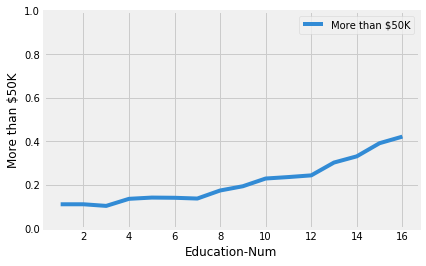

In [41]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

### PDP of 'Capital Gain' affecting model prediction

Unsurprisingly higher the capital gain, the more chance of making money, there is a steep rise in around \$5K - $8K

2018-10-30 21:58:26,363 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 6 seconds

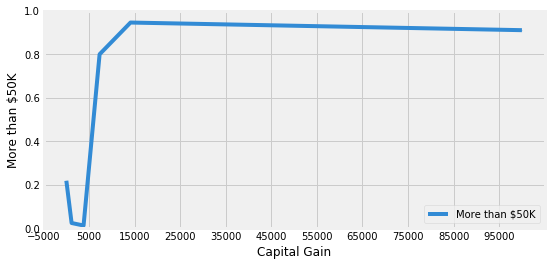

In [52]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (8, 4), n_samples=23000)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

### PDP of 'Relationship' affecting model prediction

Remember that relationship is coded as a categorical variable with numeric representations. Let's first look at how it is represened.

In [43]:
pd.concat([data_disp[['Relationship']], data[['Relationship']]], axis=1).drop_duplicates()

Relationship  Relationship
0     Not-in-family             1
1           Husband             0
4              Wife             5
12        Own-child             3
17        Unmarried             4
74   Other-relative             2

Interesting definitely that married folks (husband-wife) have a higher chance of making more money than others!

2018-10-30 21:50:53,947 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 5 seconds

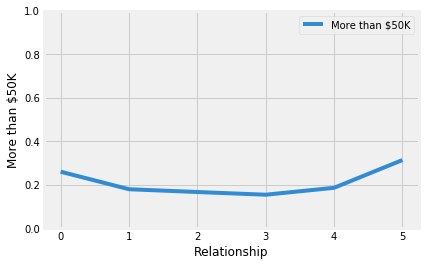

In [44]:
r = interpreter.partial_dependence.plot_partial_dependence(['Relationship'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

### Two-way PDP showing interactions between features 'Age' and 'Education-Num' and their effect on making more than \$50K

We run a deeper model interpretation here over all the data samples, trying to see interactions between `Age` and `Education-Num`and also their effect on the probability of the model predicting if the person will make more money, with the help of a two-way partial dependence plot.

Interesting to see higher the education level and the middle-aged folks (30-50) having the highest chance of making more money!

2018-10-30 22:04:17,745 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[1136/1136] grid cells ████████████████████ Time elapsed: 629 seconds

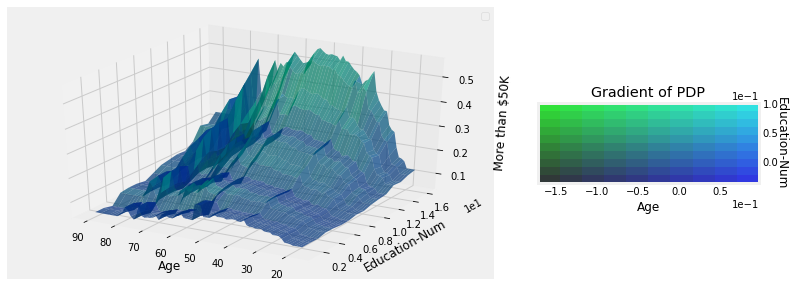

In [54]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

### Two-way PDP showing interactions between features 'Education-Num' and 'Capital Gain' and their effect on making more than \$50K

We run a deeper model interpretation here over all the data samples, trying to see interactions between `Education-Num` and `Capital Gain`and also their effect on the probability of the model predicting if the person will make more money, with the help of a two-way partial dependence plot.

Basically having a better education and more capital gain leads to you making more money!

2018-10-30 22:24:37,401 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[160/160] grid cells ████████████████████ Time elapsed: 89 seconds

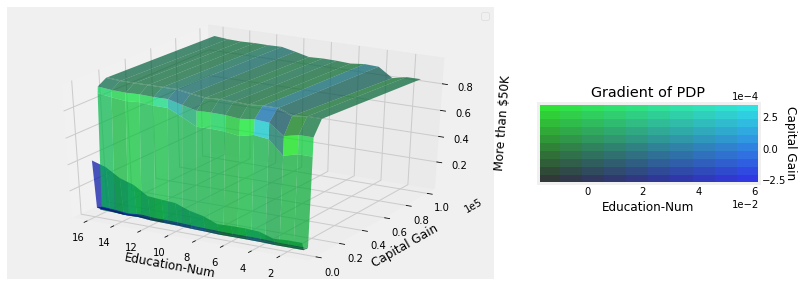

In [56]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Education-Num', 'Capital Gain')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

# Local Interpretations with Skater

Local Interpretation could be possibly be achieved in two ways. Firstly, one could possibly approximate the behavior of a complex predictive model in the vicinity of a single input using a simple interpretable auxiliary or surrogate model (e.g. Linear Regressor). Secondly, one could use the base estimator to understand the behavior of a single prediction using intuitive approximate functions based on inputs and outputs.

## Local Interpretable Model-Agnostic Explanations(LIME)
LIME is a novel algorithm designed by Riberio Marco, Singh Sameer, Guestrin Carlos to access the behavior of the any base estimator(model) using interpretable surrogate models (e.g. linear classifier/regressor). Such form of comprehensive evaluation helps in generating explanations which are locally faithful but may not align with the global behavior. Basically, LIME explanations are based on local surrogate models. These, surrogate models are interpretable models (like a linear model or decision tree) that are learned on the predictions of the original black box model. But instead of trying to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

The idea is very intuitive. To start with, just try and unlearn what you have done so far! Forget about the training data, forget about how your model works! Think that your model is a black box model with some magic happening inside, where you can input data points and get the models predicted outcomes. You can probe this magic black box as often as you want with inputs and get output predictions.

Now, you main objective is to understand why the machine learning model which you are treating as a magic black box, gave the outcome it produced. LIME tries to do this for you! It tests out what happens to you black box model's predictions when you feed variations or perturbations of your dataset into the black box model. Typically, LIME generates a new dataset consisting of perturbed samples and the associated black box model's predictions. On this dataset LIME then trains an interpretable model weighted by the proximity of the sampled instances to the instance of interest. Following is a standard high-level workflow for this.
 - Choose your instance of interest for which you want to have an explanation of the predictions of your black box model.
 - Perturb your dataset and get the black box predictions for these new points.
 - Weight the new samples by their proximity to the instance of interest.
 - Fit a weighted, interpretable (surrogate) model on the dataset with the variations.
 - Explain prediction by interpreting the local model.
 
We recommend you to read the [LIME chapter](https://christophm.github.io/interpretable-ml-book/lime.html) in Christoph Molnar's excellent book on Model Interpretation which talks about this in detail.

## Explaining Model Predictions with Skater using LIME

Skater can leverage LIME to explain model predictions. Typically, its __`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. The __`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.

Since XGBoost has some issues with feature name ordering when building models with dataframes, we will build our same model with numpy arrays to make LIME work without additional hassles of feature re-ordering. Remember the model being built is the same ensemble model which we treat as our black box machine learning model

In [60]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc_np.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [61]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=list(data.columns), 
                           discretize_continuous=True, 
                           class_names=['$50K or less', 'More than $50K'])

### Predicting when a person's income <= \$50K 

Skater gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as below \$50K

In [63]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: 0
Predicted Label: 0


### Predicting when a person's income > \$50K 

Skater gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as above \$50K

In [70]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: 1
Predicted Label: 1


## Path to more interpretable models with Tree Surrogates using Skater

We have see various ways to interpret machine learning models with features, dependence plots and even LIME. But can we build an approximation or a surrogate model which is more interpretable from a really complex black box model like our XGBoost model having hundreds of decision trees?

Here in, we introduce the novel idea of using __`TreeSurrogates`__ as means for explaining a model's learned decision policies (for inductive learning tasks), which is inspired by the work of Mark W. Craven described as the TREPAN algorithm. 

We recommend checking out the following excellent papers on the TREPAN algorithm to build surrogate trees.
 - [_Mark W. Craven(1996) EXTRACTING COMPREHENSIBLE MODELS FROM TRAINED NEURAL NETWORKS_](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/craven.thesis.pdf)
 - [_Mark W. Craven and Jude W. Shavlik(NIPS, 96). Extracting Thee-Structured Representations of Thained Networks_](https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf)

Briefly, Trepan constructs a decision tree in a best-first manner. It maintains a queue of leaves which are expanded into subtrees as they are removed from the queue. With each node in the queue, Trepan stores,

 - a subset of the training examples, 
 - another set of instances (query instances),
 - a set of constraints. 

The stored subset of training examples consists simply of those examples that reach the node. The query instances are used, along with the training examples, to select the splitting test if the node is an internal node or to determine the class
label if it is a leaf. The constraint set describes the conditions that instances must satisfy in order to reach the node; this information is used when drawing a set of query instances for a newly created node. The process of expanding a node in Trepan is much like it is in conventional decision tree algorithms: a splitting test is selected for the node, and a child is created for each outcome of the test. Each child is either made a leaf of the tree or put into the queue for future expansion.


For Skater's implementation, for building explainable surrogate models, the base estimator(Oracle) could be any form of a supervised learning predictive model - our black box model. The explanations are approximated using Decision Trees(both for Classification/Regression) by learning decision boundaries similar to that learned by the Oracle (predictions from the base model are used for learning the Decision Tree representation). The implementation also generates a fidelity score to quantify tree based surrogate model’s approximation to the Oracle. Ideally, the score should be 0 for truthful explanation both globally and locally. Let's check this out in action!

__NOTE:__ :: Experimental :: The implementation is currently experimental and might change in future.

### Using the interpreter instance invoke call to the TreeSurrogate

In [235]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=42)

### Using the surrogate model to learn the decision boundaries learned by the base estimator
 - Reports the fidelity value when compared to the base estimator (closer to 0 is better)
 - Learner uses F1 score as the default metric of choice for classification.

In [236]:
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2018-10-31 01:49:32,614 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-10-31 01:49:32,617 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-10-31 01:49:34,119 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (22792, 2)
2018-10-31 01:49:34,136 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.889; oracle score 0.898


0.009

### Taking a look at the position for each feature
- We do this since the feature names in the surrogate tree are not displayed (but are present in the model)

In [228]:
pd.DataFrame([('X'+str(idx), feature) for (idx, feature) in enumerate(data.columns)]).T

0          1              2               3           4             5   \
0   X0         X1             X2              X3          X4            X5   
1  Age  Workclass  Education-Num  Marital Status  Occupation  Relationship   

     6    7             8             9               10       11  
0    X6   X7            X8            X9             X10      X11  
1  Race  Sex  Capital Gain  Capital Loss  Hours per week  Country

### Visualizing the Surrogate Tree

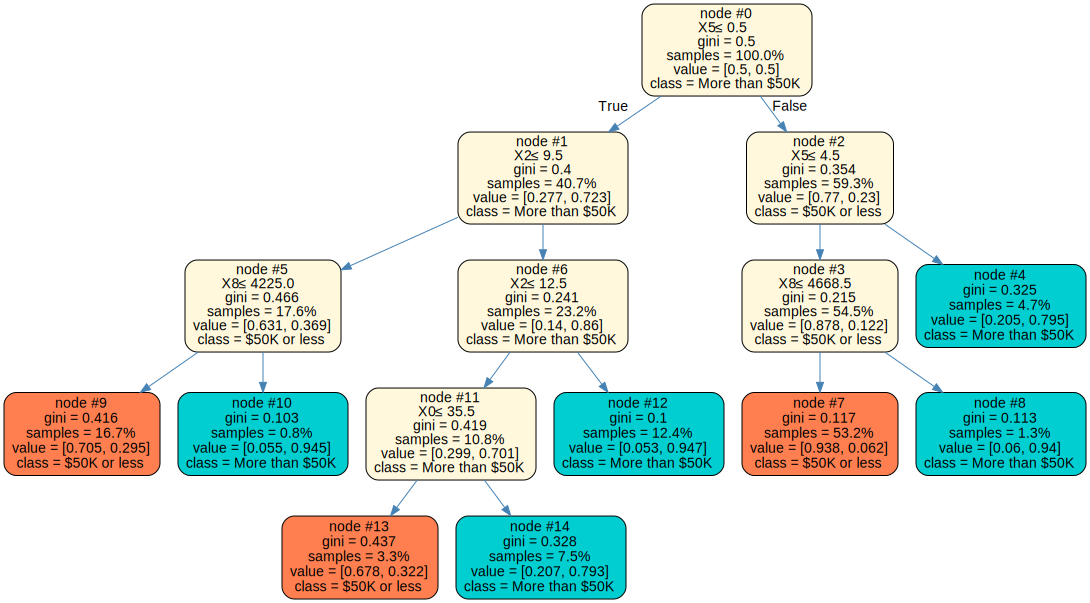

In [220]:
from skater.util.dataops import show_in_notebook
from graphviz import Source
from IPython.display import SVG

graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png').to_string())
svg_data = graph.pipe(format='svg')
with open('dtree_structure.svg','wb') as f:
    f.write(svg_data)
SVG(svg_data)

### Interesting rules from the surrogate tree

Here are some interesting rules you can observe from the above tree
- If `Relationship` < 0.5 (means 0) and `Education-num` <= 9.5 and `Capital Gain` <= 4225 __→__ 70% chance of person making <= \$50K 
- If `Relationship` < 0.5 (means 0) and `Education-num` <= 9.5 and `Capital Gain` >= 4225 __→__ 94.5% chance of person making > \$50K 
- If `Relationship` < 0.5 (means 0) and `Education-num` >= 9.5 and `Educatin-num` is also >= 12.5 __→__ 94.7% chance of person making > \$50K 

Feel free to derive more interesting rules from this and also your own models! Let's look at how our surrogate model performs on the test dataset now

### Surrogate Model Performance Evaluation

Just as expected, the model performance drops a fair bit but still we get an overall F1 score of 83% as compared to our boosted model's score of 87% which is quite good!

In [237]:
surrogate_predictions = surrogate_explainer.predict(X_test)
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=surrogate_predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8273
Precision: 0.8333
Recall: 0.8273
F1 Score: 0.8299

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      7455
           1       0.62      0.68      0.65      2314

   micro avg       0.83      0.83      0.83      9769
   macro avg       0.76      0.78      0.77      9769
weighted avg       0.83      0.83      0.83      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6504   951
        1        736  1578


# Model Interpretation with SHAP

**SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on what they claim! (do check out the [SHAP NIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).



### Install

SHAP can be installed from [PyPI](https://pypi.org/project/shap)

```
pip install shap
```

or [conda-forge](https://anaconda.org/conda-forge/shap)

```
conda install -c conda-forge shap 
```

The really awesome aspect about this framework is while SHAP values can explain the output of any machine learning model, for really complex ensemble models it can be slow. But they have developed a high-speed exact algorithm for tree ensemble methods ([Tree SHAP arXiv paper](https://arxiv.org/abs/1802.03888)). Fast C++ implementations are supported for *XGBoost*, *LightGBM*, *CatBoost*, and *scikit-learn* tree models!

SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. Its novel components include: the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach. 

An intuitive way to understand the Shapley value is the following: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value __$ϕ_{ij}$__ is the average marginal contribution of feature value __$x_{ij}$__ by joining whatever features already entered the room before, i.e.

$$\phi_{ij}=\sum_{\text{All.orderings}}val(\{\text{features.before.j}\}\cup{}x_{ij})-val(\{\text{features.before.j}\})$$

The following figure from the KDD 18 paper, [_Consistent Individualized Feature Attribution for Tree Ensembles_](https://arxiv.org/pdf/1802.03888.pdf) summarizes this in a nice way!

![](https://i.imgur.com/6Rc1dsa.png)

Let's now dive into SHAP and leverage it for interpreting our model!

## Explain predictions with SHAP

Here we use the Tree SHAP implementation integrated into XGBoost to explain the test dataset! Remember that there are a variety of explainer methods based on the type of models you are building. We estimate the SHAP values for a set of samples (test data)

In [238]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)

In [248]:
pd.DataFrame(shap_values).head()

0         1         2         3         4         5         6   \
0 -1.209206 -0.003895 -0.073927 -1.078541 -0.645259 -0.517731 -0.002871   
1  0.354368 -0.262398 -0.483883  0.586233  0.307967  1.194750  0.017408   
2 -0.525650  0.030637  0.970991  0.360480  0.528695  0.603971 -0.103895   
3 -0.426095  0.076188  0.576406 -1.108961 -0.517884 -0.522604  0.028896   
4 -0.503867 -0.159754 -0.129339 -0.547773 -0.049194 -0.414065 -0.019701   

         7         8         9         10        11  
0 -0.421329 -0.144742 -0.036394 -0.568053 -0.004587  
1 -0.216272 -0.108322 -0.048158 -0.095782  0.017657  
2  0.050630 -0.176231 -0.087669  0.509656  0.024573  
3 -0.359870 -0.142805 -0.057430 -0.250736  0.023183  
4  0.128197 -3.685364 -0.031033  0.781617  0.001285

This returns a matrix of SHAP values (`# samples x # features`). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as `expected_value` attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

In [255]:
print('Expected Value:', explainer.expected_value)

Expected Value: -1.3625857


### Predicting when a person's income <= \$50K 

SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as below \$50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [249]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

### Predicting when a person's income > \$50K 

Similarly, SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as greater than \$50K.

In [252]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

## Visualizing and explaining multiple predictions

One of the key advantages of SHAP is it can build beautiful interactive plots which can visualize and explain multiple predictions at once. Here we visualize model prediction decisions for the first 1000 test data samples.

In [256]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_disp.iloc[:1000,:])

The above visualization can be interacted with in multiple ways. The default visualization shows some interesting model prediction pattern decisions.

- The first 100 test samples all probably __earn more than \$50K__ and they __are married__ or\and have a __good capital gain__ or\and have a __higher education level__!
- The next 170+ test samples all probably __earn less than or equal to \$50K__ and they __are mostly un-married__ and\or are __very young in age or divorced__!
- The next 310+ test samples have an inclination towards mostly __earning more than \$50K__ and they are of diverse profiles including married folks, people with different age and education levels and occupation. Most dominant features pushing the model towards making a prediction for higher income is the person being married i.e. __relationship: husband or wife__!
- The remaining 400+ test samples have an inclination towards mostly __earning less than \$50K__ and they are of diverse profiles however dominant patterns include __relationship: either unmarried or divorced__ and __very young in age__! 

Definitely interesting how we can find out patterns which lead to the model making specific decisions and being able to provide explanations for them.

## Feature Importances with SHAP

This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

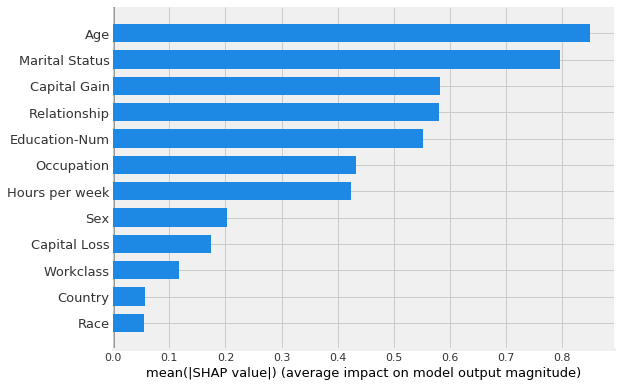

In [257]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## SHAP Summary Plot

Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the age and marital status feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age or marital status. In other words, capital gain effects a few predictions by a large amount, while age or marital status effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

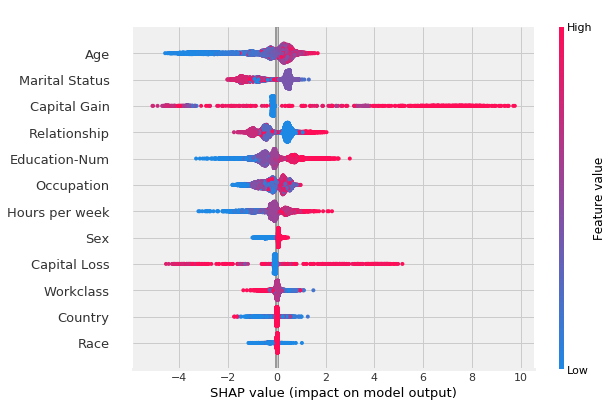

In [258]:
shap.summary_plot(shap_values, X_test)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

You will also notice it's similarity with Skater's Partial Dependence Plots!

### PDP of 'Age' affecting model prediction

Just like we observed before. the middle-aged people have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to younger or older people

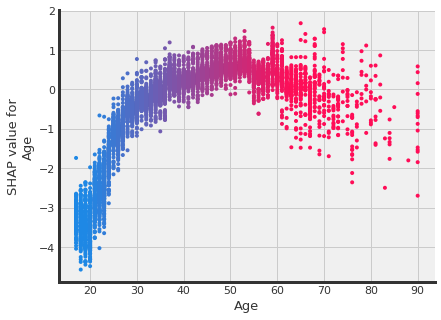

In [262]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Education-Num' affecting model prediction

Higher education levels have higher shap values, pushing the model's prediction decisions to say that these individuals make more money as compared to people with lower education levels

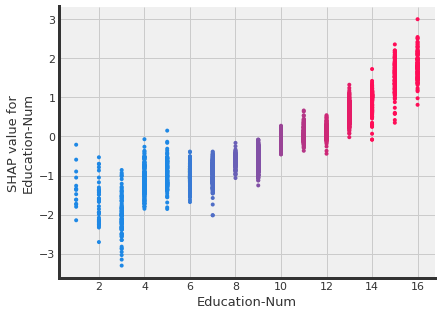

In [264]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Relationship' affecting model prediction

Just like we observed during the model prediction explanations, married people (husband or wife) have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to other folks!

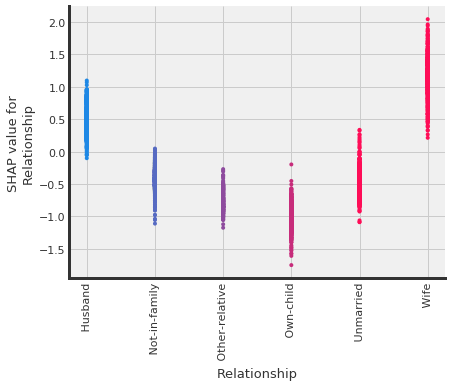

In [265]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Capital Gain' affecting model prediction

You might have observed a very similar plot in the Skater PDPs, here typically a Capital Gain of more than \$5K - \$8K leads to a huge spike in the SHAP values making the model push towards prediction decisions to say that these individuals make more money as compared to others!

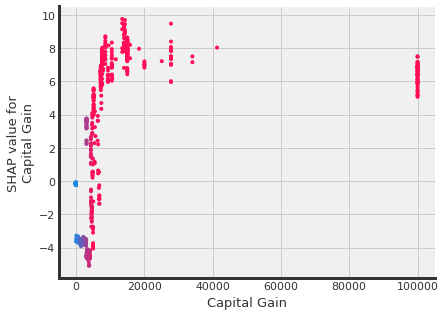

In [266]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Age' and 'Capital Gain' and their effect on making more than \$50K

The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. Here we are trying to see interactions between `Age` and `Capital Gain`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Interesting to see higher the higher capital gain and the middle-aged folks (30-50) having the highest chance of making more money!

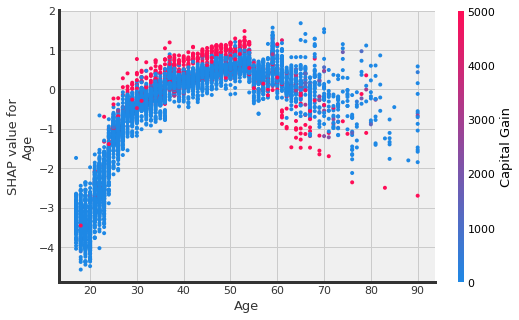

In [267]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Education-Num' and 'Relationship' and their effect on making more than \$50K

Here we are trying to see interactions between `Education-Num` and `Relationship`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Interesting to see higher the higher education level and the husband or wife (married) folks having the highest chance of making more money!

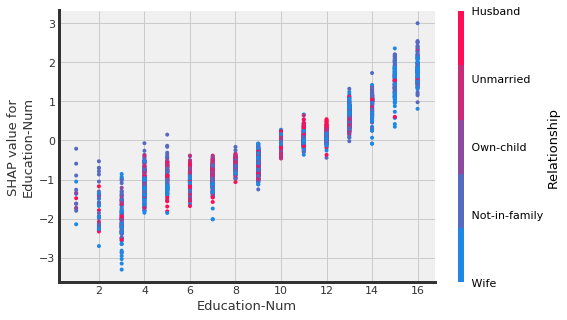

In [277]:
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Marital Status' and 'Relationship' and their effect on making more than \$50K

Here we are trying to see interactions between `Marital Status` and `RElationship`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

This is interesting because both the features are similar in some context, we can see typically married people with relationship status of either husband or wife having the highest chance of making more money!

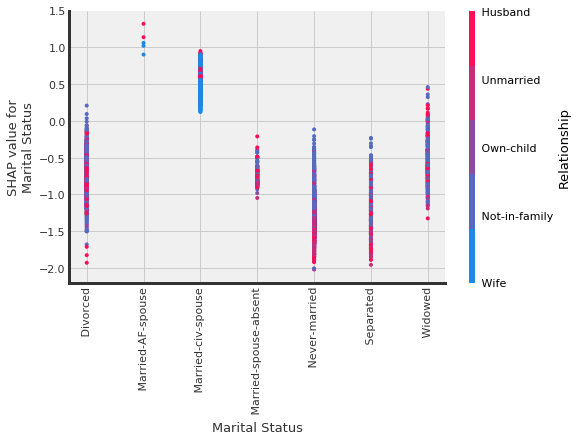

In [269]:
shap.dependence_plot(ind='Marital Status', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Age' and 'Hours per week' and their effect on making more than \$50K

Here we are trying to see interactions between `Age` and `Hours per week`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Nothing extra-ordinary here, middle-aged people working the most make the most money!

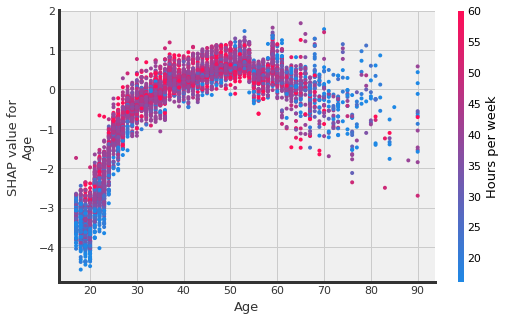

In [278]:
shap.dependence_plot(ind='Age', interaction_index='Hours per week', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

# Final Words

If you are reading this, I would like to really commend your efforts on going through this comprehensive tutorial on machine learning model interpretation and encourage you to try out some of these frameworks with your own models and datasets and explore the world of model interpretation!